In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

In [23]:
class system_parameters:
    def __init__(self, r_star, r_planet, period, inclination, semi, ecc, omega):
        #Taking inputs and initializing the required parameters for plotting the light curve for the system.
        self.r_s= r_star
        self.r_p= r_planet
        self.P=period
        self.i=inclination
        self.a= semi*215.032 #from au to solar radii
        self.e= ecc
        self.w= np.pi*omega/180
        self.Delta()
        self.impact()
        self.total_time()
        self.time_f()
        self.t_periastron()
        
    def Delta(self):
        #Function to calculate delta
        self.delta= (self.r_p/self.r_s)**2
        
    def total_time(self):
        #Function to calculate the ratio of total transit time and period
        t_Tc= ((self.P/np.pi*(self.r_s/self.a))*np.sqrt((1+self.delta)**2-(self.a*np.cos(np.deg2rad(self.i))/self.r_s)**2))/self.P
        #The above transit time is for circular orbits. Now, to calculate for eccentric orbits.
        temp1= 1- (self.b)**2
        temp2= 1-(self.e)**2
        temp3= 1+self.e*np.sin(self.w)
        self.t_T= t_Tc*np.sqrt(temp1*temp2)/temp3
        
    def time_f(self):
        #Function to calculate tf/P 
        self.t_f=self.t_T*np.sqrt((1-self.delta)**2-(self.a*np.cos(np.deg2rad(self.i))/self.r_s)**2)/np.sqrt((1+self.delta)**2-(self.a*np.cos(np.deg2rad(self.i))/self.r_s)**2)
    
    def impact(self):
        #Function to calculate b
        self.b= (self.a/self.r_s)*np.cos(np.deg2rad(self.i))
    
    def parameters(self):
        print(self.r_s,self.r_p,self.P,self.i,self.a,self.delta,self.t_T,self.t_f, self.b)
        
    def t_periastron(self):
        temp1= np.sqrt((1-self.e)/(1+self.e))
        temp2= np.tan(self.w/2)
        E= 2*np.arctan(temp1*temp2)
        self.tp= (E- self.e*np.sin(E))/(2*np.pi)
        if self.tp<0:
            self.tp= 1+self.tp
        print(self.tp)

In [24]:
#Using the parameters of HD1397
test= system_parameters(2.336,0.1026,11.53,90,0.1097,0.251,270)
#test.parameters()

0.8290487504513719


In [25]:
def fun(tT,tf,d,m, x):
    #Function to define a piece-wisely defined function for the basic light curve.
    y=[]
    for i in range(len(x)):
        if x[i]<(0.5-tT/2):
            y.append(1)
        elif (0.5-tT/2)<=x[i]<(0.5-tf/2):
            y.append(-m*x[i]+1+m*(0.5-tT/2))
        elif (0.5-tf/2)<=x[i]<(0.5+tf/2):
            y.append(1-d)
        elif (0.5+tf/2)<=x[i]<(0.5+tT/2):
            y.append(m*x[i]+1-m*(0.5+tT/2))
        elif x[i]>=(0.5+tT/2):
            y.append(1)
    
    arr=np.array(y)
    
    return arr
    

In [26]:
def light_curve(system):
    #Function to plot the light curve based on the piece-wisely defined function.
    new_lum= 1-(0.7*system.delta)
    trans_time= (system.t_T-system.t_f)/2
    m= (system.delta)/trans_time
    
    x = np.linspace(0,1, 50000)
    y = fun(system.t_T,system.t_f,system.delta,m,x)
    
    #Plotting
    plt.plot(x,y)
    plt.xlabel("t/P")
    plt.ylabel("L/L_star")
    plt.xlim(0.4,0.6)
    plt.ylim(0.994,1.001)
    

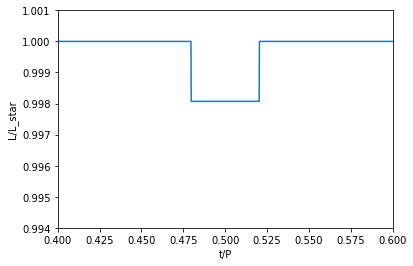

In [27]:
light_curve(test)

In [28]:
def limb():
    #Function to plot relative intensity as a function of angle.
    u= 0.65 #sun
    x= np.linspace(0,90, 100)
    rel_intensity= 1-u*(1-np.cos(np.deg2rad(x)))
    plt.plot(x, rel_intensity)
    plt.xlim(0,100)
    plt.xlabel("theta (deg)")
    plt.ylabel("Relative intensity")
    plt.title("Stellar limb darkening")
    

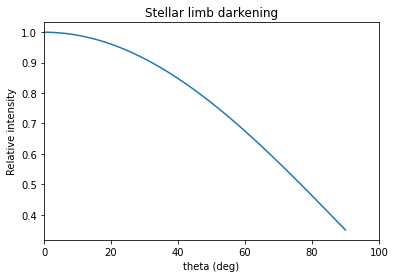

In [29]:
limb()

In [30]:
def limbfactor(t,tf):
    #Function to calculate the limb darkening factor 'f' for some given time 't' of the transit
    u=0.65
    f=0
    if t<0.5:
        theta=(90-180*t)/tf
        f= 1-u*(1-np.cos(np.deg2rad(theta))) 
    elif t>=0.5:
        theta= (180*t-90)/tf
        f= 1-u*(1-np.cos(np.deg2rad(theta)))
    return f

In [31]:
print(limbfactor(0.5-test.t_f/2,test.t_f))

0.34999999999999887


In [32]:
def light_curve1(system):
    #Function to plot the light curve with limb darkening.
    d=limbfactor(0.5-system.t_f/2,system.t_f)*system.delta
    lum= 1-d #lum at the start of the transit
    trans_time= (system.t_T-system.t_f)/2
    m= (d)/trans_time
    
    t=np.linspace(0,1,100000)
    y = fun(system.t_T,system.t_f,d,m,t)
    
    for i in range(len(t)):
        if (0.5-system.t_f/2)<t[i]<(0.5+system.t_f/2):
            y[i]= y[i]+d -limbfactor(t[i], system.t_f)*system.delta
    
    print(t[np.where(y==min(y))]) 
    #plotting
    fig = plt.figure()
    #fig.set_facecolor('black')
    ax1 = fig.add_subplot(111)

    ax1.plot(t,y)
    ax1.set_xlabel("t/P")
    #ax1.xaxis.label.set_fontsize(18)
    ax1.set_ylabel("L/L_star")
    #ax1.yaxis.label.set_fontsize(18)
    ax1.set_title("Observed luminosity")
    #ax1.title.set_fontsize(18)
    #ax1.set_facecolor("black")
    #ax1.spines['bottom'].set_color('white')
    #ax1.spines['top'].set_color('white') 
    #ax1.spines['right'].set_color('white')
    #ax1.spines['left'].set_color('white')
    #ax1.tick_params(axis='x', colors='white')
    #ax1.tick_params(axis='y', colors='white')
    #ax1.title.set_color('white')
    #ax1.yaxis.label.set_color('white')
    #ax1.xaxis.label.set_color('white')
    #ax1.tick_params(axis='both', labelsize=12)
    ax1.set_xlim(0.4,0.6)
    #ax1.set_ylim(0.994,1.001)

[0.499995 0.500005]


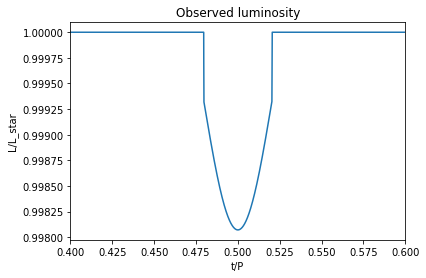

In [33]:
light_curve1(test)

In [34]:
def e_angle(E,t,e,tp):
    #Function to calculate the roots of the transcendental equation. To get E
    if t>tp:
        return E- e*np.sin(E)- 2*np.pi*(t-tp)
    else:
        return E- e*np.sin(E)- 2*np.pi*(1-t+tp)

In [35]:
def true_anomaly(f,E,e):
    #Function to calculate the true anomaly given the eccentric anomaly
    temp= np.sqrt((1+e)/(1-e))
    return np.tan(f/2)- temp*np.tan(E/2)

In [42]:
def limbfactor2(t, tf, e, a, w, R, tp):
    #Function to calculate the limbfactor as a function of time (including eccentricity)
    u=0.65
    estimate= 2*np.pi*t
    E= fsolve(e_angle, estimate, args=(t,e,tp))
    true_ano= fsolve(true_anomaly, estimate, args=(E,e))
    
    temp= a*(1-e**2)
    temp2= 1+ e*np.cos(true_ano)
    r= temp/temp2
    temp_angle= 1.5*np.pi- w- true_ano
    
    limb_theta= (-np.pi*r*np.sin(temp_angle))/(2*R)
    #print(r*np.sin(temp_angle)/(R))
    f= 1-u*(1-np.cos(limb_theta))
    return f

In [43]:
def light_curve2(system):
    #Function to plot the light curve with limb darkening AND eccentricity.
    
    d=limbfactor2(0.5-system.t_f/2,system.t_f,system.e, system.a,system.w,system.r_s,system.tp)*system.delta
    lum= 1-d #lum at the start of the transit
    trans_time= (system.t_T-system.t_f)/2
    m= (d)/trans_time
    
    t=np.linspace(0,1,100000)
    y = fun(system.t_T,system.t_f,d,m,t)
    
    for i in range(len(t)):
        if (0.5-system.t_f/2)<t[i]<(0.5+system.t_f/2):
            y[i]= y[i]+d -limbfactor2(t[i], system.t_f, system.e,system.a,system.w,system.r_s,system.tp)*system.delta
       
    plt.plot(t,y)
    plt.xlim(0.4,0.6)

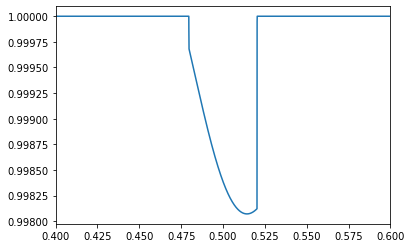

In [44]:
light_curve2(test)